# Trabajo Práctico 2

## 1. Implemente un perceptrón simple que aprenda la función lógica AND y la función lógica OR, de 2 y de 4 entradas. Muestre la evolución del error durante el entrenamiento. Para el caso de 2 dimensiones, grafique la recta discriminadora y todos los vectores de entrada de la red.

### Perceptrón simple – funciones y flujo (con *bias* absorbido, versión con historial)

**Objetivo:** entrenar un perceptrón (activación signo) para aprender **AND/OR** con 2 y 4 entradas, actualizando **patrón por patrón** y registrando tanto el **ECM por época** como el **historial de pesos** (para visualizar la frontera de decisión *epoch a epoch*).

Usamos el *bias* absorbido como **una entrada constante 1**, así todos los pesos se actualizan con la misma regla.

---

### Funciones incluidas

- **`step(h)`**  
  Activa con **signo**: devuelve `+1` si $h \ge 0$ y $-1$ si $h < 0$.

- **`augment_with_bias(X)`**  
  Agrega una columna de unos: $X \mapsto \tilde{X} = [X \mid \mathbf{1}]$ (la última columna representa la entrada del *bias*).

- **`forward_aug(X_{\mathrm{aug}}, w_{\mathrm{aug}})`**  
  Calcula la salida **discreta** del perceptrón:
  $$
  O \;=\; \mathrm{sgn}\!\big(\tilde{X}\,\tilde{\mathbf{w}}\big).
  $$

- **`predict(X, w_{\mathrm{aug}})`**  
  Conveniencia: aplica `augment_with_bias` y luego `forward_aug` para predecir desde $X$ (no aumentada).

- **`mse(y, \hat{y})`**  
  **ECM** sobre salidas discretas $\{-1,+1\}$:
  $$
  \mathrm{ECM} \;=\; \frac{1}{P}\sum_{i=1}^{P}\big(y_i-\hat{y}_i\big)^2
  $$
  (equivale a $4\times$ la tasa de error cuando $y,\hat{y}\in\{-1,+1\}$).

- **`train_perceptron_aug_with_history(X, y, \eta, \text{max\_epochs}, \text{shuffle}, \text{random\_state})`**  
  Entrena **en línea** (muestra por muestra) con **vector aumentado**.  
  Inicializa $\tilde{\mathbf{w}} \sim \mathcal{N}(0, 0.01)$ y, **solo si hay error**, aplica la regla del perceptrón:
  $$
  \tilde{\mathbf{w}}\;\leftarrow\;\tilde{\mathbf{w}}+\eta\,t\,\tilde{\mathbf{x}},
  $$
  donde $t\in\{-1,+1\}$, $\tilde{\mathbf{x}}=[\mathbf{x};1]$ y la **última componente** de $\tilde{\mathbf{w}}$ es el **peso del bias**.  
  Devuelve:
  - `w_hist`: matriz $\big(E \times (N+1)\big)$ con los pesos **al final de cada época** (incluye el bias).
  - `ecms`: lista con el **ECM por época**.  
  Se detiene temprano si en una época no hay errores (separación perfecta).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def step(h: np.ndarray) -> np.ndarray:
    """Signo: +1 si h>=0, -1 si h<0."""
    return np.where(h >= 0, 1, -1)

def augment_with_bias(X: np.ndarray) -> np.ndarray:
    """Agrega una columna de 1s: X -> [X | 1]. El último peso es el bias."""
    X = np.asarray(X, dtype=float)
    ones = np.ones((X.shape[0], 1), dtype=float)
    return np.hstack([X, ones])

def forward_aug(X_aug: np.ndarray, w_aug: np.ndarray) -> np.ndarray:
    """Salida del perceptrón con X """
    return step(X_aug @ w_aug)

def predict(X: np.ndarray, w_aug: np.ndarray) -> np.ndarray:
    """Predice a partir de X (no aumentada)."""
    return forward_aug(augment_with_bias(X), w_aug)

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """ECM sobre etiquetas en {+1,-1}."""
    y_true = np.asarray(y_true)
    return float(np.mean((y_true - y_pred) ** 2))

# -------------------------
# Entrenamiento con HISTORIAL por ÉPOCA
# -------------------------
def train_perceptron_aug_with_history(
    X: np.ndarray,
    y: np.ndarray,
    eta: float = 0.1,
    max_epochs: int = 100,
    shuffle: bool = False,
    random_state: int | None = None,
):
    rng = np.random.default_rng(random_state)
    X_aug = augment_with_bias(X)
    y = np.asarray(y, dtype=int)

    w_aug = rng.normal(0, 0.01, size=X_aug.shape[1])

    w_hist = []
    ecms = []

    for _ in range(max_epochs):
        if shuffle:
            idx = rng.permutation(len(X_aug))
            Xe, ye = X_aug[idx], y[idx]
        else:
            Xe, ye = X_aug, y

        mistakes = 0
        for xi, ti in zip(Xe, ye):
            if step(xi @ w_aug) != ti:
                w_aug += eta * ti * xi
                mistakes += 1

        # log de fin de época SIEMPRE
        w_hist.append(w_aug.copy())
        ecms.append(mse(y, forward_aug(X_aug, w_aug)))

        if mistakes == 0:  # early stop si separó perfecto
            break

    return np.array(w_hist), np.array(ecms)


- **`dataset_gate(gate)`**  
  Genera el dataset de la compuerta lógica elegida (**AND** u **OR**):  
  $X=\{(0,0),(0,1),(1,0),(1,1)\}$ y  
  $y=\{-1,-1,-1,+1\}$ (AND) / $y=\{-1,+1,+1,+1\}$ (OR).

- **`plot_boundary_on_ax(ax, w_{\text{aug}})`**  
  Dibuja la **frontera de decisión** del perceptrón en 2D.  
  Con $w_{\text{aug}}=[w_1,w_2,w_0]$ (siendo $w_0$ el *bias*), la recta es:
  $$
  w_1 x_1 + w_2 x_2 + w_0 = 0
  \;\;\Rightarrow\;\;
  x_2 = -\frac{w_1 x_1 + w_0}{w_2}
  $$
  (si $w_2=0$, la frontera es vertical: $x_1=-\tfrac{w_0}{w_1}$).

- **`annotate_points(ax, X, y)`**  
  Plotea los puntos de $X$ y etiqueta cada clase ($+1$ / $-1$).

- **`run_experiment_for_gate(gate, \{\eta\})`**  
  Para la compuerta elegida, recorre una lista de tasas de aprendizaje $\eta$, y para cada una:
  1) **Entrena** con `train_perceptron_aug_with_history` (ya definida antes) y obtiene  
     el **historial de pesos por época** $w_{\text{hist}}$ y el **ECM por época**.  
  2) Grafica **ECM vs. época**.  
  3) Muestra, en un **panel lateral**, la **evolución de la recta** (una subfigura por época).


In [2]:
def dataset_gate(gate: str = "AND", dim: int = 2):
    g = gate.strip().lower()
    if dim == 2:
        X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
        if g == "and":
            y = np.array([-1,-1,-1, 1], dtype=int)
        elif g == "or":
            y = np.array([-1, 1, 1, 1], dtype=int)
        else:
            raise ValueError("gate debe ser 'AND' u 'OR'")
        return X, y
    elif dim == 4:
        X = np.array([[int(b) for b in f"{i:04b}"] for i in range(16)], dtype=float)
        if g == "and":
            y = np.array([-1]*15 + [1], dtype=int)
        elif g == "or":
            y = np.array([-1] + [1]*15, dtype=int)
        else:
            raise ValueError("gate debe ser 'AND' u 'OR'")
        return X, y
    else:
        raise ValueError("dim debe ser 2 o 4")


def plot_boundary_on_ax(ax, w_aug, eps: float = 1e-12):
    """Dibuja la frontera de decisión en el eje ax dado w_aug."""
    w1, w2, wb = w_aug
    x_vals = np.linspace(-0.2, 1.2, 200)
    if abs(w2) > eps:
        y_vals = -(w1 * x_vals + wb) / w2
        ax.plot(x_vals, y_vals, linewidth=2)
    elif abs(w1) > eps:
        ax.axvline(x=-wb / w1, linewidth=2)


def annotate_points(ax, X, y):
    """Plotea puntos y etiquetas de clase."""
    X_pos = X[y == 1]; X_neg = X[y == -1]
    ax.scatter(X_pos[:,0], X_pos[:,1], label="+1")
    ax.scatter(X_neg[:,0], X_neg[:,1], label="-1")
    for pt, lab in zip(X, y):
        ax.annotate(str(int(lab)), (pt[0]+0.02, pt[1]+0.02), fontsize=9)
    ax.set_xlim(-0.2, 1.2); ax.set_ylim(-0.2, 1.2)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
    ax.grid(True)

def run_experiment_for_gate(
    gate: str = "AND",
    etas = (0.01, 0.05, 0.1, 0.5, 1.0),
    max_epochs: int = 100,
    shuffle: bool = False,
    random_state: int = 42,
):
    """
    Para la compuerta 'gate' entrena con cada eta, grafica:
      (1) ECM vs. época y (2) evolución lateral de la frontera por época.
    Requiere train_perceptron_aug_with_history(X,y,eta,...) definido previamente.
    """
    X, y = dataset_gate(gate)
    for eta in etas:
        w_hist, ecms = train_perceptron_aug_with_history(
            X, y, eta=eta, max_epochs=max_epochs, shuffle=shuffle, random_state=random_state
        )

        xs = np.arange(1, len(ecms)+1)
        plt.figure(figsize=(5,3))
        if len(ecms) == 1:
            plt.scatter(xs, ecms, s=60)
        else:
            plt.plot(xs, ecms, marker='o')
        plt.xlabel("Época"); plt.ylabel("ECM")
        plt.title(f"ECM por época – {gate.upper()} (2) – η={eta}")
        plt.grid(True)
        plt.show()

        n_ep = len(w_hist)
        fig, axes = plt.subplots(1, n_ep, figsize=(3*n_ep, 3), sharex=True, sharey=True)
        if n_ep == 1:
            axes = [axes]

        for i, ax in enumerate(axes, start=1):
            annotate_points(ax, X, y)
            plot_boundary_on_ax(ax, w_hist[i-1])
            ax.set_title(f"época {i}")
            if i == 1:
                ax.legend(loc="upper left", frameon=True)

        fig.suptitle(f"{gate.upper()} (2) – evolución de la frontera – η={eta}", y=1.05, fontsize=12)
        plt.tight_layout()
        plt.show()


Analizamos **exclusivamente la compuerta lógica AND (2 entradas)**: entrenamos un perceptrón, registramos el **ECM por época** y mostramos, **para cada** $\eta$, dos gráficos: (1) **ECM vs. época** y (2) la **evolución de la recta discriminadora** *epoch a epoch*. (No se usa OR en este bloque.)


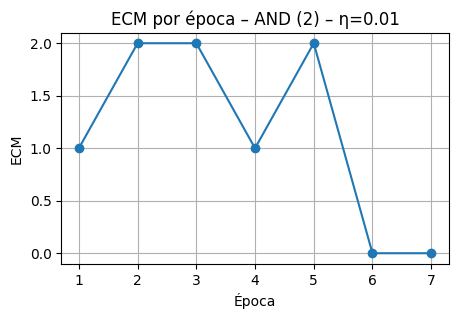

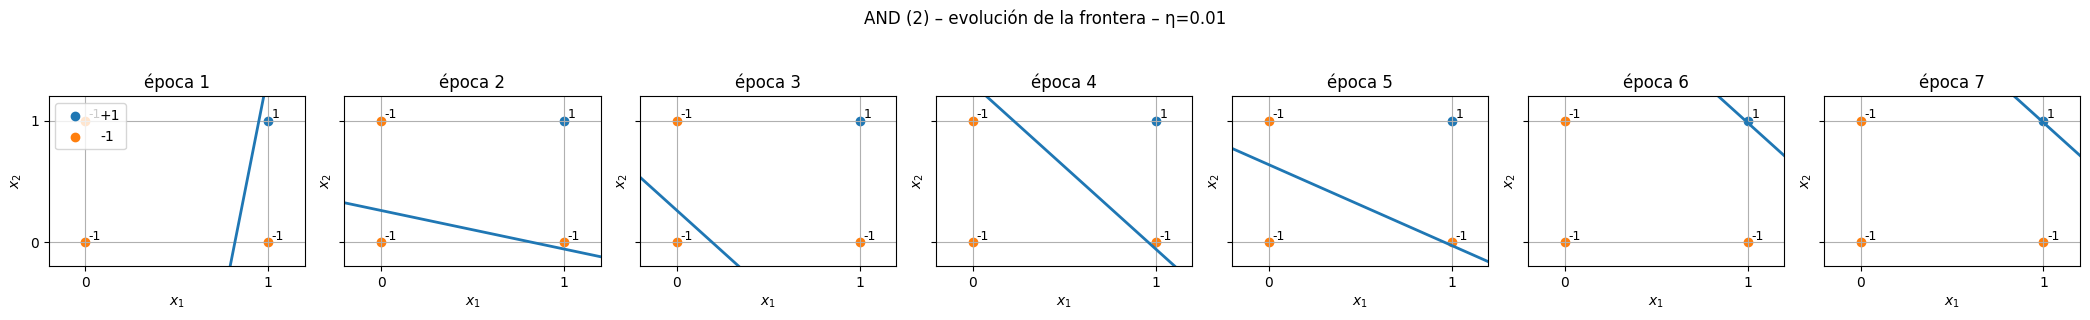

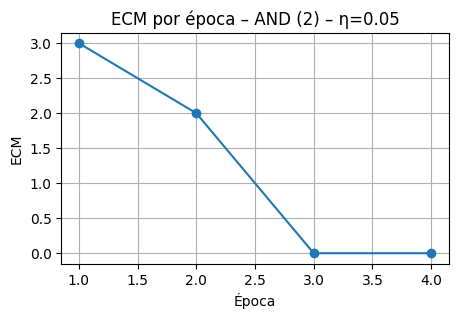

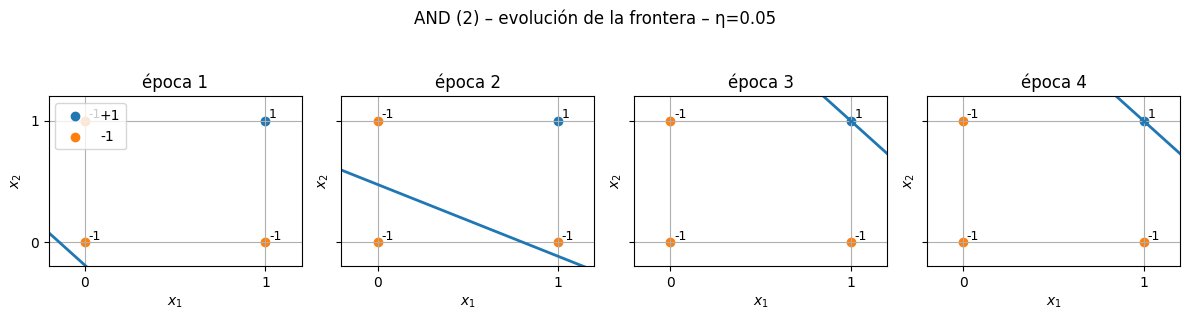

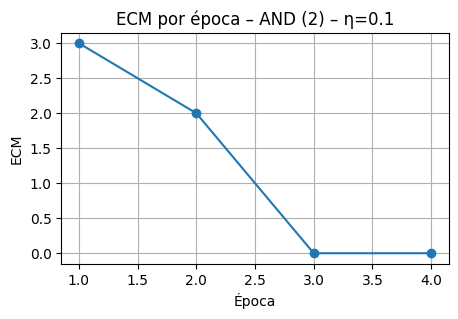

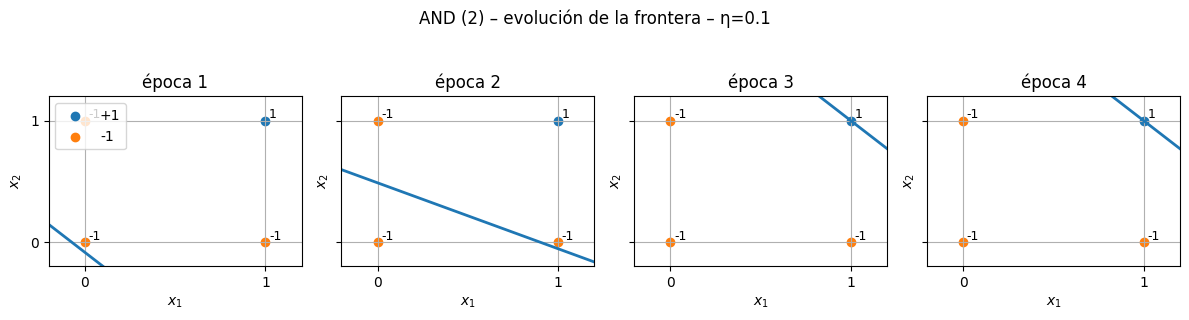

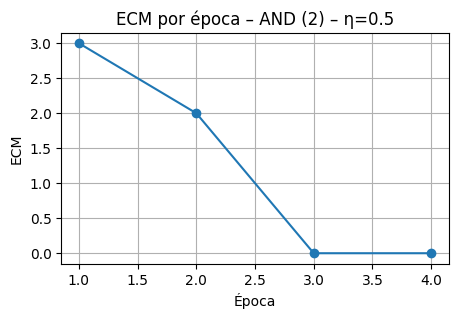

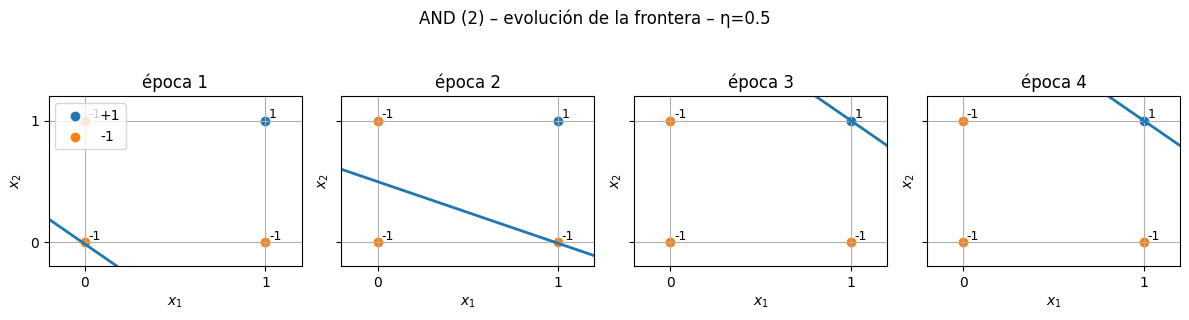

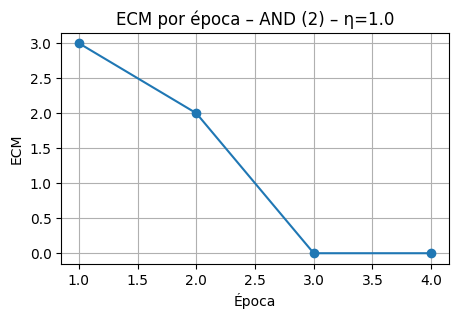

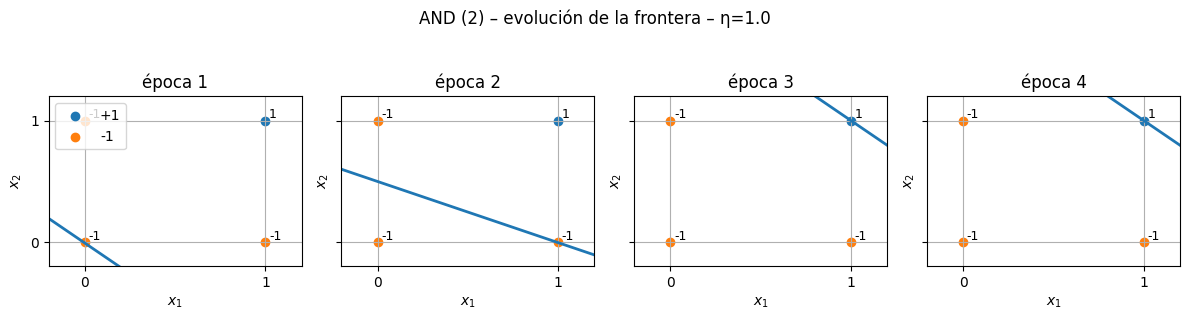

In [3]:
run_experiment_for_gate("AND", etas=[0.01, 0.05, 0.1, 0.5, 1.0], max_epochs=100, shuffle=False, random_state=42)


Analizamos **exclusivamente la compuerta lógica OR (2 entradas)**: entrenamos un perceptrón, registramos el **ECM por época** y mostramos, **para cada** $\eta$, dos gráficos: (1) **ECM vs. época** y (2) la **evolución de la recta discriminadora** *epoch a epoch*.  
Datos usados: $X\in\{0,1\}^2$ y $y=\{-1,\; +1,\; +1,\; +1\}$. (No se usa AND en este bloque.)


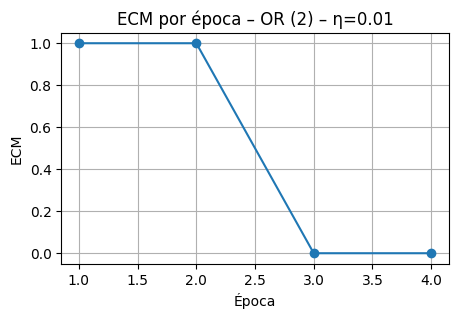

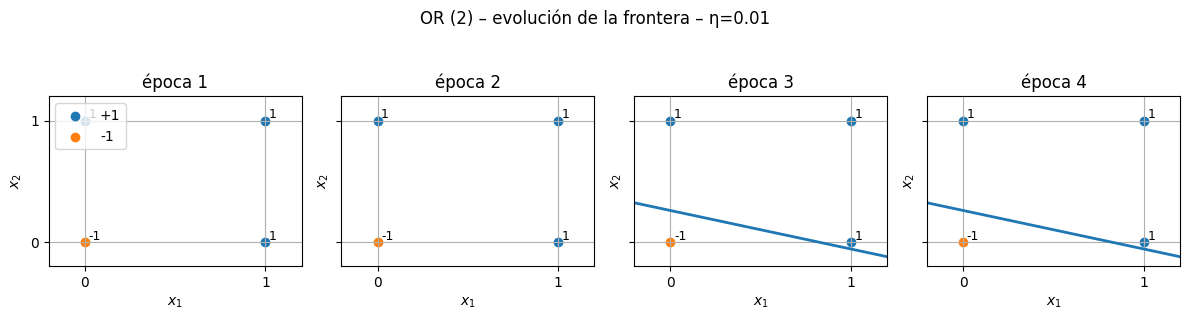

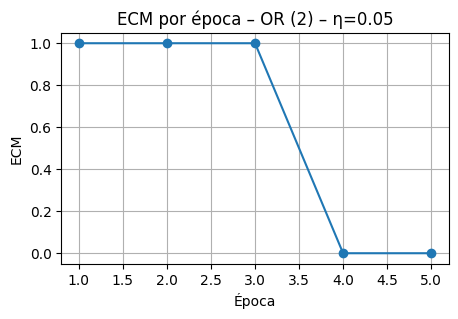

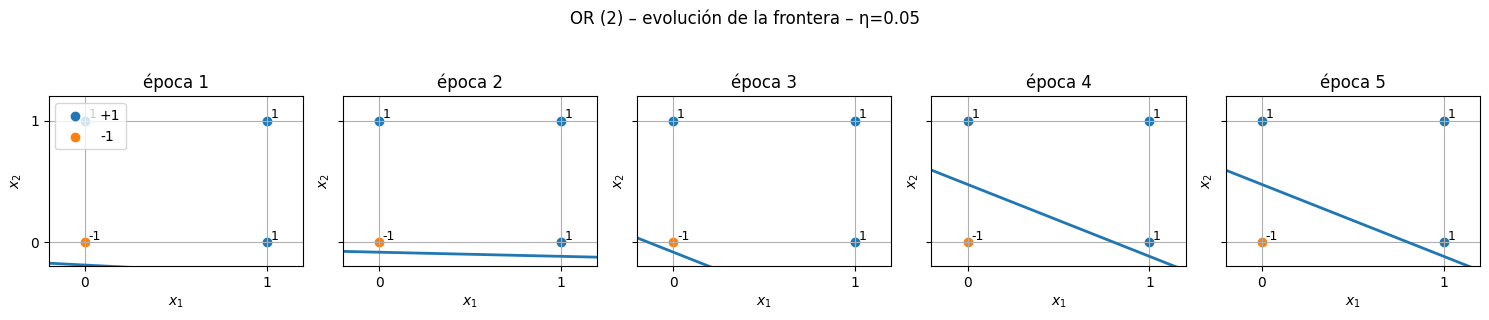

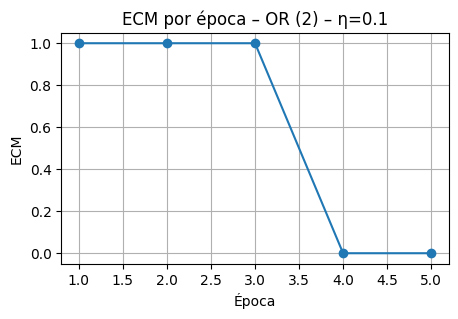

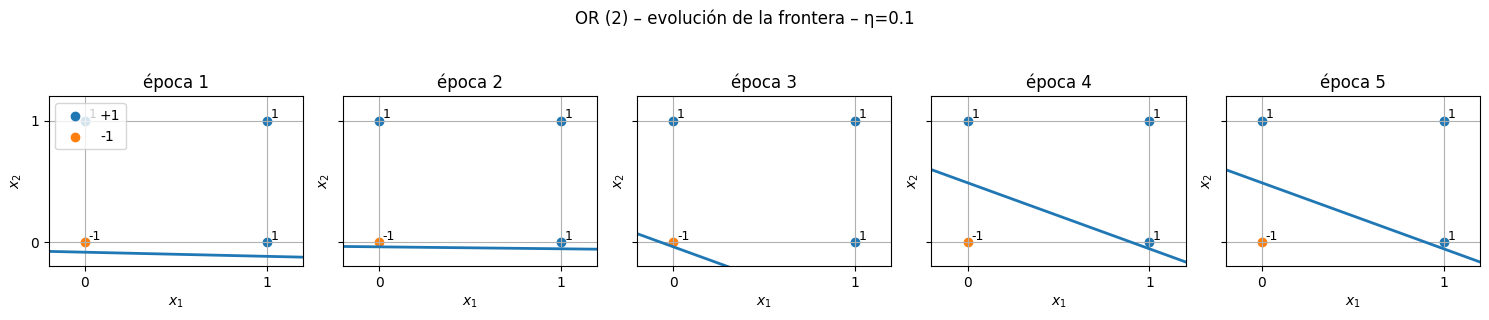

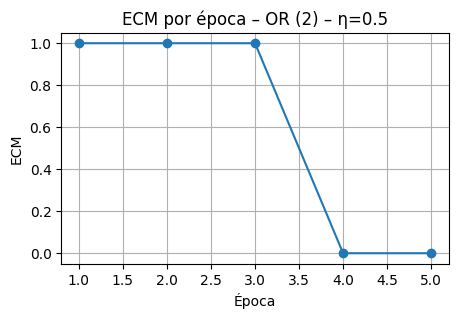

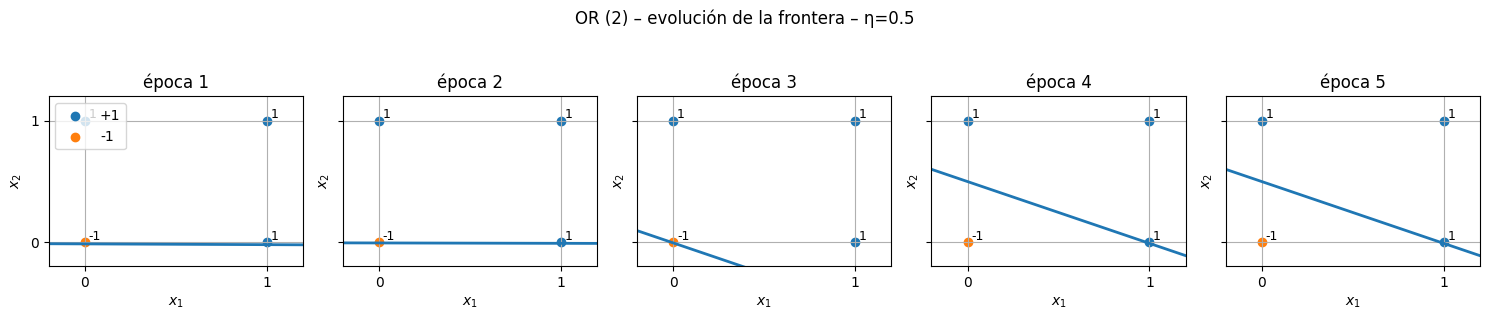

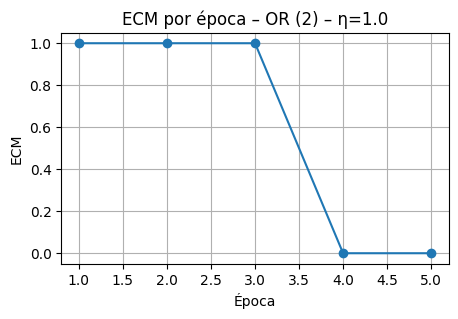

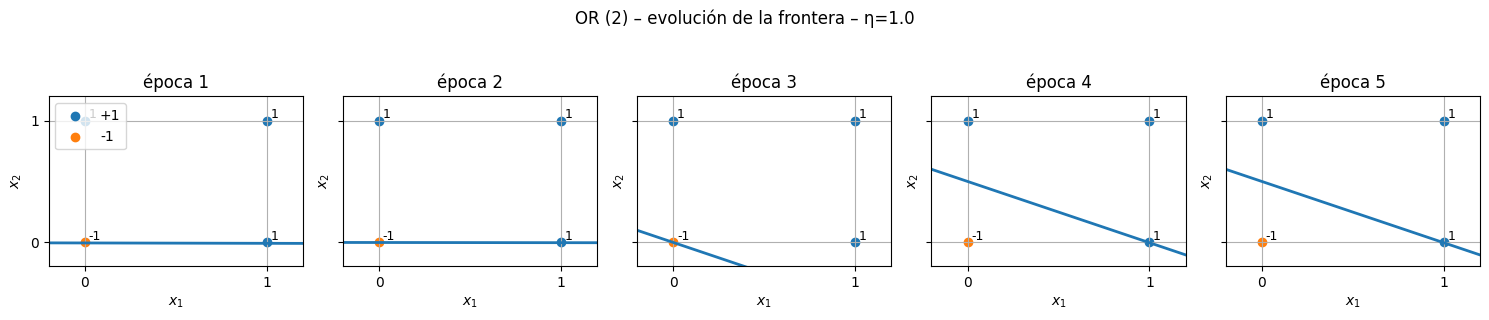

In [4]:
run_experiment_for_gate("OR", etas=[0.01, 0.05, 0.1, 0.5, 1.0], max_epochs=100, shuffle=False, random_state=42)


# 2. Determine numéricamente cómo varía la capacidad del perceptrón simple en función del número de patrones enseñados. 

## Experimento de Capacidad del Perceptrón Simple

El objetivo es estimar **cuántos patrones aleatorios puede aprender un perceptrón simple con $N$ entradas**.  
La idea central es que el perceptrón solo puede resolver problemas **linealmente separables**, es decir, aquellos donde existe un hiperplano en $\mathbb{R}^N$ que divide perfectamente a las dos clases.

---

### Metodología del experimento

1. **Generación de problemas aleatorios:**  
   - Se eligen $N$ (número de entradas) y $N_p$ (número de patrones).  
   - Cada patrón es un vector $x \in [-1,1]^N$ generado al azar.  
   - A cada patrón se le asigna una etiqueta $y \in \{-1,+1\}$ también al azar.

2. **Entrenamiento del perceptrón:**  
   - Se entrena con regla del perceptrón clásico hasta un máximo de épocas.  
   - Se considera que el problema fue **aprendido** solo si el perceptrón logra error de entrenamiento exactamente 0:
     $$
     \forall i,\;\; \hat{y}_i = y_i
     $$

3. **Estimación de la fracción aprendida:**  
   - Se repite el procedimiento muchas veces (trials independientes).  
   - Se calcula:
     $$
     \text{frac}(N_p) \;=\; \frac{\# \text{problemas aprendidos}}{\text{trials}}
     $$

4. **Curvas de capacidad:**  
   - Para cada $N$, se varía $N_p$ desde 1 hasta un múltiplo de $N$ (por ejemplo, $5N$).  
   - Se grafica la fracción aprendida en función de $N_p$.  

---

### Qué vamos a medir

- Eje $x$: número de patrones $N_p$.  
- Eje $y$: fracción de problemas aprendidos (probabilidad de separabilidad lineal).  

El resultado son curvas que empiezan en 1 (pocos patrones casi siempre separables) y decaen hacia 0 (muchos patrones casi nunca separables).  
El **punto medio** ($N_p^*$) se toma como la **capacidad empírica del perceptrón**, definida como el número de patrones que puede aprender en promedio.

---

### Resultado esperado

Según la teoría clásica (Cover, 1965), la capacidad está en torno a:
$$
N_p^* \;\approx\; 2N
$$

Es decir, un perceptrón simple puede aprender, en promedio, hasta aproximadamente el **doble de patrones que la cantidad de entradas** antes de que la probabilidad de éxito caiga al 50%.


In [5]:
def _predict_from_w(X, w_aug):
    """Predicción {+1,-1} usando vector aumentado y pesos finales."""
    Xa = augment_with_bias(X)
    return np.where(Xa @ w_aug >= 0, 1, -1)

def _trial_learned_once(N: int, Np: int, eta=0.1, max_epochs=200, rng=None) -> bool:
    """
    Un problema aleatorio continuo:
      - X ~ U([-1,1]^N) de tamaño Np
      - y ∈ {-1,+1} al azar
    Entrena perceptrón; True si clasifica 100% en training.
    """
    if rng is None:
        rng = np.random.default_rng()
    X = rng.uniform(-1.0, 1.0, size=(Np, N))
    y = rng.choice([-1, 1], size=Np)

    # random_state distinto por trial (para inicialización)
    rs = int(rng.integers(0, 1_000_000))
    w_hist, _ = train_perceptron_aug_with_history(
        X, y, eta=eta, max_epochs=max_epochs, shuffle=False, random_state=rs
    )
    yhat = _predict_from_w(X, w_hist[-1])
    return bool(np.all(yhat == y))

def capacity_sweep(Ns, k_factor=5, trials=100, eta=0.1, max_epochs=500, seed=2025):
    """
    Para cada N y Np=1..k_factor*N, estima la fracción de problemas
    aprendidos (linealmente separables) por el perceptrón.
    Devuelve: dict N -> (Np_values, frac_learned)
    """
    rng_master = np.random.default_rng(seed)
    results = {}
    for N in Ns:
        Np_vals = np.arange(1, k_factor * N + 1)
        fracs = np.empty_like(Np_vals, dtype=float)
        for j, Np in enumerate(Np_vals):
            success = 0
            for _ in range(trials):
                rng = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
                success += _trial_learned_once(N, int(Np), eta=eta, max_epochs=max_epochs, rng=rng)
            fracs[j] = success / trials
        results[N] = (Np_vals, fracs)
    return results

def half_capacity_point(Np_vals, fracs):
    """Np* donde la fracción está más cerca de 0.5 (estimación de capacidad)."""
    idx = int(np.argmin(np.abs(fracs - 0.5)))
    return int(Np_vals[idx]), float(fracs[idx])


## Experimento ejecutado: Capacidad empírica del perceptrón simple

En este bloque de código variamos **la dimensión del perceptrón ($N$)** y el número de **trials** (repeticiones del experimento aleatorio) para estimar de manera robusta la capacidad.

---

### Configuración usada

- **Dimensiones comparadas ($N$):** $2, 4, 8, 20, 30$  
- **Cantidad de patrones probados ($N_p$):** desde 1 hasta $5 \cdot N$ (con `k_factor=5`).  
- **Tasa de aprendizaje:** $\eta = 0.1$  
- **Épocas máximas:** 500  
- **Semilla aleatoria:** 2854  
- **Número de trials:** $50$, $100$ y $500$

---

### Qué se midió

1. Para cada $N$ y cada $N_p$, se generaron problemas aleatorios con entradas continuas en $[-1,1]^N$ y salidas en $\{-1,+1\}$.  
2. Se entrenó un perceptrón simple y se contó como **aprendido** solo si alcanzó **error de entrenamiento 0**.  
3. Se repitió el procedimiento varias veces (`trials`) y se calculó la **fracción de problemas aprendidos**:
   $$
   \text{frac}(N_p) \;=\; \frac{\# \text{problemas aprendidos}}{\text{trials}}
   $$
4. Se graficó la curva $\text{frac}(N_p)$ para cada $N$ y se marcó con una línea roja punteada la referencia teórica en $2N$.  

---

### Resultados esperados

- Las curvas comienzan cerca de 1 (cuando $N_p$ es chico, casi siempre son separables).  
- A medida que $N_p$ aumenta, la fracción de problemas aprendidos cae hacia 0.  
- El punto medio ($N_p^*$, donde la fracción ≈ 0.5) aparece aproximadamente en $2N$, confirmando la predicción teórica de que la capacidad del perceptrón simple es cercana al doble de la dimensión de entrada.

---


In [6]:
# Config global
#Ns         = (2, 4, 8, 20, 30)     # dimensiones a comparar
Ns = (4,)
k_factor   = 5             # Np max = k_factor * N
eta        = 0.1
max_epochs = 500
seed       = 2854
#trials_list = [10, 50, 100, 500]
trials_list = []

for trials in trials_list:
    print(f"\n=== TRIALS = {trials} ===")
    results = capacity_sweep(
        Ns=Ns, k_factor=k_factor, trials=trials,
        eta=eta, max_epochs=max_epochs, seed=seed
    )

    # Plots por N
    for N, (Np_vals, fracs) in results.items():
        plt.figure(figsize=(5,3.5))
        plt.plot(Np_vals, fracs, marker='o', label="Fracción aprendida")

        # --- MARCA en 2N ---
        plt.axvline(2*N, color="red", linestyle="--", label=f"2N={2*N}")

        plt.xlabel("Número de patrones (Np)")
        plt.ylabel("Fracción aprendida")
        plt.title(f"Capacidad empírica – Perceptrón simple (N={N}) | trials={trials}")
        plt.ylim(-0.02, 1.02)
        plt.grid(True)
        plt.legend()
        plt.show()

    # Resumen de Np* (fracción ≈ 0.5)
    print("Np* (aprox. fracción≈0.5) por N:")
    for N, (Np_vals, fracs) in results.items():
        Np_star, frac = half_capacity_point(Np_vals, fracs)
        print(f"  N={N}: Np*≈{Np_star} (fracción={frac:.2f})")


# 3. Implemente un perceptrón multicapa que aprenda la función lógica XOR de 2 y de 4 entradas (utilizando el algoritmo Backpropagation y actualizando en batch). Muestre cómo evoluciona el error durante el entrenamiento. 

Este código implementa una red neuronal multicapa (MLP)

### 1. **Funciones de Activación**

Las funciones de activación son fundamentales para introducir no linealidad en el modelo, lo que le permite aprender representaciones complejas. El código soporta las siguientes funciones de activación:

- **Sigmoid**: 
  $$ \sigma(x) = \frac{1}{1 + e^{-x}} $$
  - La salida es entre 0 y 1. Comúnmente usada para problemas de clasificación binaria.

- **Tanh**: 
  $$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$
  - La salida es entre -1 y 1, y es útil cuando se necesita que los valores estén centrados alrededor de 0.

- **ReLU (Rectified Linear Unit)**: 
  $$ \text{ReLU}(x) = \max(0, x) $$
  - Amplia la activación de las neuronas y es muy utilizada por su eficiencia computacional y su capacidad para evitar el desvanecimiento del gradiente.

- **Identidad (Linear)**: 
  $$ f(x) = x $$
  - Usada típicamente en la capa de salida para problemas de regresión, donde la salida puede ser cualquier número real.

Cada función tiene también su derivada correspondiente, que se usa durante el proceso de retropropagación (backpropagation).

### 2. **Inicialización de Pesos**

La **inicialización de los pesos** en redes neuronales es crucial para un buen entrenamiento. En este código, se utilizan dos métodos de inicialización de pesos:

- **Inicialización de Xavier/Glorot**: 
  Esta inicialización es adecuada para funciones de activación como **sigmoid**, **tanh** o **linear**. Los pesos se inicializan con una distribución uniforme con el siguiente límite:
  $$ \text{limite} = \sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}} $$

- **Inicialización de He**: 
  Usada para **ReLU**. Se inicializan los pesos con una distribución normal con desviación estándar:
  $$ \text{std} = \sqrt{\frac{2}{\text{fan\_in}}} $$

En ambos casos, los **bias** se inicializan a 0.

### 3. **Red Neuronal Multicapa (MLP)**

La clase `MLP` representa una red neuronal multicapa con la posibilidad de tener múltiples capas ocultas y de salida. Esta clase permite realizar las siguientes operaciones:

3.1 **Forward Pass**

El **forward pass** calcula la salida de la red para una entrada dada. Para cada capa, la salida se calcula como:

$$
Z = A \cdot W + b
$$
donde \( A \) es la activación de la capa anterior, \( W \) es el peso de la capa actual, y \( b \) es el bias.

La salida de cada capa se pasa a través de la función de activación correspondiente.

3.2 **Backward Pass (Retropropagación)**

En el **backpropagation**, se calculan los gradientes de los pesos y biases con respecto a la pérdida usando la regla de la cadena. La derivada de la función de activación se aplica a los errores para ajustar los pesos de la red.

La fórmula para calcular los gradientes de los pesos y biases es:

$$
\delta_i = g'(Z_i) \cdot (C_i - O_i)
$$
donde \( \delta_i \) es el error de la capa \( i \), \( g'(Z_i) \) es la derivada de la activación, y \( C_i \) y \( O_i \) son el valor objetivo y la salida de la red, respectivamente.

3.3 **Actualización de Pesos**

Después de calcular los gradientes, los pesos y biases se actualizan usando la regla de gradiente descendente. El aprendizaje es controlado por la tasa de aprendizaje (\( \eta \)):

$$
W_i = W_i - \eta \cdot \nabla W_i
$$
donde \( \nabla W_i \) es el gradiente de los pesos.

### 4. **Entrenamiento (fit)**

El método `fit()` entrena la red utilizando **mini-batches**. Durante el entrenamiento, la red realiza un **forward pass**, calcula la pérdida, realiza el **backward pass** y actualiza los pesos con la regla de gradiente descendente. El error de la red se guarda durante cada época de entrenamiento, y el modelo se evalúa con un conjunto de validación si se proporciona.

- **Early Stopping**: Si se proporciona un conjunto de validación, el entrenamiento puede detenerse temprano si el error de validación deja de mejorar después de un número de épocas.

### 5. **Predicción**

El método `predict()` se utiliza para realizar predicciones usando el modelo entrenado. Devuelve la salida de la red para un conjunto de entradas.

### 6. **Clasificación**

El método `predict_classes()` devuelve las predicciones de clase para problemas de clasificación. Si la salida es binaria (solo una neurona en la capa de salida), usa un umbral (por defecto 0.5) para decidir si la clase es 0 o 1. Si la salida es de varias clases (una neurona por clase), toma la clase con la activación más alta.

---

Este código implementa una red neuronal completa con múltiples capas ocultas y de salida, y proporciona los elementos necesarios para entrenar y hacer predicciones en tareas de clasificación y regresión. La inicialización de los pesos y las funciones de activación juegan un papel clave en la eficiencia del entrenamiento y el rendimiento del modelo.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Utilidades: activaciones
# ------------------------------
class Activations:
    @staticmethod
    def sigmoid(x):
        # numéricamente estable
        x = np.clip(x, -60, 60)
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def d_sigmoid(a):
        # derivada en función de la salida activada (a = sigmoid(x))
        return a * (1.0 - a)

    @staticmethod
    def tanh(x):
        # np.tanh ya es estable
        return np.tanh(x)

    @staticmethod
    def d_tanh(a):
        # derivada en función de la salida activada (a = tanh(x))
        return 1.0 - a**2

    @staticmethod
    def relu(x):
        return np.maximum(0.0, x)

    @staticmethod
    def d_relu(a):
        return (a > 0.0).astype(a.dtype)

    @staticmethod
    def identity(x):
        return x

    @staticmethod
    def d_identity(a):
        return np.ones_like(a)

ACTS = {
    "sigmoid": (Activations.sigmoid, Activations.d_sigmoid),
    "tanh":    (Activations.tanh,    Activations.d_tanh),
    "relu":    (Activations.relu,    Activations.d_relu),
    "linear":  (Activations.identity,Activations.d_identity),
    "identity":(Activations.identity,Activations.d_identity),
}

# ------------------------------
# Inicialización de pesos
# ------------------------------
def weight_init(fan_in, fan_out, act_name, rng):
    """
    Xavier (sigmoid/tanh/linear) o He (ReLU). Retorna W, b.
    """
    act = act_name.lower()
    if act in ("relu",):
        # He normal
        std = np.sqrt(2.0 / fan_in)
    else:
        # Xavier/Glorot uniforme
        limit = np.sqrt(6.0 / (fan_in + fan_out))
        W = rng.uniform(-limit, limit, size=(fan_in, fan_out))
        b = np.zeros((1, fan_out))
        return W, b

    W = rng.normal(0.0, std, size=(fan_in, fan_out))
    b = np.zeros((1, fan_out))
    return W, b

# ------------------------------
# MLP
# ------------------------------
class MLP:
    def __init__(
        self,
        layer_sizes,                          # lista: [n_in, h1, h2, ..., n_out]
        activations,                          # lista de nombres p/ cada capa no-lineal (len = len(layer_sizes)-1)
        seed=42,
        l2=0.0,
        learning_rate=0.05,
        clip_grad=None,                       # e.g. 5.0 para clipping global (norma)
        dtype=np.float64
    ):
        self.layer_sizes = layer_sizes
        self.activations = [a.lower() for a in activations]
        self.rng = np.random.default_rng(seed)
        self.l2 = float(l2)
        self.lr = float(learning_rate)
        self.clip_grad = clip_grad
        self.dtype = dtype

        # Pesos y biases
        self.W = []
        self.b = []
        for l in range(len(layer_sizes)-1):
            fan_in, fan_out = layer_sizes[l], layer_sizes[l+1]
            Wi, bi = weight_init(fan_in, fan_out, self.activations[l], self.rng)
            self.W.append(Wi.astype(dtype))
            self.b.append(bi.astype(dtype))

        # Cache para forward
        self._Z = []  # preactivaciones (linear)
        self._A = []  # activaciones (post g)

    # ---------- Forward ----------
    def forward(self, X, store_cache=True):
        A = X.astype(self.dtype, copy=False)
        if store_cache:
            self._Z = []
            self._A = [A]  # guardar entrada como A0
        for l, act_name in enumerate(self.activations):
            Z = A @ self.W[l] + self.b[l]              # (batch, fan_out)
            act, _ = ACTS[act_name]
            A = act(Z)
            if store_cache:
                self._Z.append(Z)
                self._A.append(A)
        return A

    # ---------- Pérdida (ECM) ----------
    @staticmethod
    def mse(y_true, y_pred):
        return 0.5 * np.mean((y_true - y_pred)**2)

    # ---------- Backprop ----------
    def backward(self, y_true, y_pred):
        batch = y_true.shape[0]
        deltas = [None] * len(self.W)
        dW = [None] * len(self.W)
        db = [None] * len(self.W)

        l = len(self.W) - 1
        _, d_act = ACTS[self.activations[l]]
        A_L = self._A[-1]
        dE_dA = (A_L - y_true) / batch
        delta = d_act(A_L) * dE_dA
        deltas[l] = delta
        dW[l] = self._A[l].T @ delta + self.l2 * self.W[l]   
        db[l] = np.sum(delta, axis=0, keepdims=True)

        for l in range(len(self.W)-2, -1, -1):
            _, d_act = ACTS[self.activations[l]]
            A_l = self._A[l+1]
            Z_l = self._Z[l]
            delta = (deltas[l+1] @ self.W[l+1].T) * d_act(A_l)
            deltas[l] = delta
            dW[l] = self._A[l].T @ delta + self.l2 * self.W[l]
            db[l] = np.sum(delta, axis=0, keepdims=True)

        if self.clip_grad is not None:
            total_norm = 0.0
            for g in dW + db:
                total_norm += np.sum(g*g)
            total_norm = np.sqrt(total_norm)
            if total_norm > self.clip_grad:
                factor = self.clip_grad / (total_norm + 1e-12)
                for i in range(len(dW)):
                    dW[i] *= factor
                    db[i] *= factor

        return dW, db

    # ---------- Update (SGD) ----------
    def step(self, dW, db):
        for i in range(len(self.W)):
            self.W[i] -= self.lr * dW[i]
            self.b[i] -= self.lr * db[i]

    def fit(self, X, y, epochs=2000, batch_size=32, shuffle=True, X_val=None, y_val=None, early_stopping=False, patience=50, verbose=True, log_every=50):
        X = X.astype(self.dtype, copy=False)
        y = y.astype(self.dtype, copy=False)
        
        if X.shape[0] != y.shape[0]:
            raise ValueError(f"Las dimensiones de X y y no coinciden: X tiene {X.shape[0]} muestras, y tiene {y.shape[0]} muestras.")
        
        n = X.shape[0]
        history = {"loss": [], "val_loss": []}
        
        for epoch in range(1, epochs + 1):
            if shuffle:
                idx = np.random.permutation(n)
                X, y = X[idx], y[idx]

            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)  
                Xb = X[start:end]
                yb = y[start:end]

                y_pred = self.forward(Xb, store_cache=True)
                dW, db = self.backward(yb, y_pred)
                self.step(dW, db)

            train_pred = self.forward(X, store_cache=False)
            loss = self.mse(y, train_pred)
            history["loss"].append(loss)

            if X_val is not None and y_val is not None:
                val_pred = self.forward(X_val, store_cache=False)
                val_loss = self.mse(y_val, val_pred)
                history["val_loss"].append(val_loss)

            if early_stopping and val_loss is not None:
                if val_loss + 1e-12 < best_val:
                    best_val = val_loss
                    wait = 0
                    best_state = (
                        [Wi.copy() for Wi in self.W],
                        [bi.copy() for bi in self.b],
                    )
                else:
                    wait += 1
                    if wait >= patience:
                        if verbose:
                            print(f"Early stopping en epoch {epoch}. Mejor val_loss = {best_val:.6f}")
                        if best_state is not None:
                            self.W, self.b = best_state
                        break

            if verbose and (epoch % log_every == 0 or epoch == 1 or epoch == epochs):
                msg = f"[{epoch:4d}] loss={loss:.6f}"
                if val_loss is not None:
                    msg += f" | val_loss={val_loss:.6f}"
                print(msg)

            if early_stopping and wait >= patience:
                break

        return history

    # ---------- Predicción ----------
    def predict(self, X):
        return self.forward(X, store_cache=False)

    # ---------- Helpers para clasificación ----------
    def predict_classes(self, X, threshold=0.5):
        yhat = self.predict(X)
        if yhat.shape[1] == 1:
            return (yhat >= threshold).astype(int)
        else:
            return np.argmax(yhat, axis=1)


Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.01...
Último error: 0.125635
Error promedio: 0.126168
Desviación estándar del error: 0.000377
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


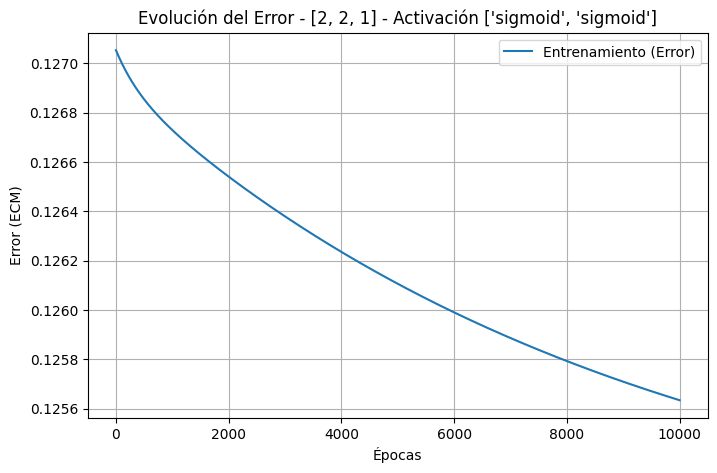

Entrenando con Red 2 -> 4 -> 1 (Sigmoid) - LR: 0.05...
Último error: 0.112105
Error promedio: 0.121430
Desviación estándar del error: 0.003596
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


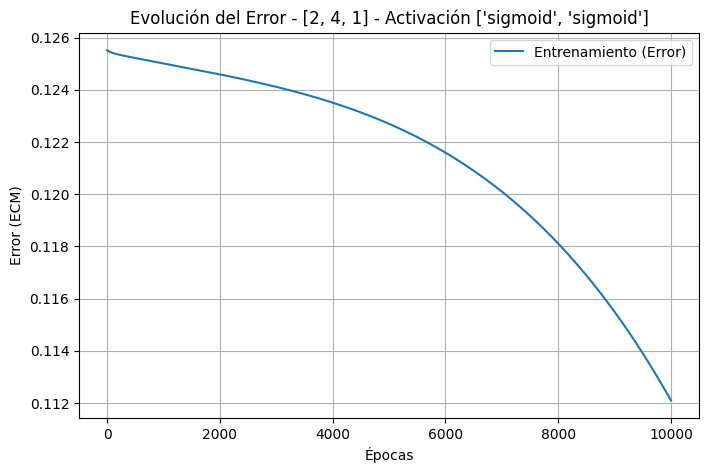

Entrenando con Red 2 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.123527
Error promedio: 0.124592
Desviación estándar del error: 0.000659
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


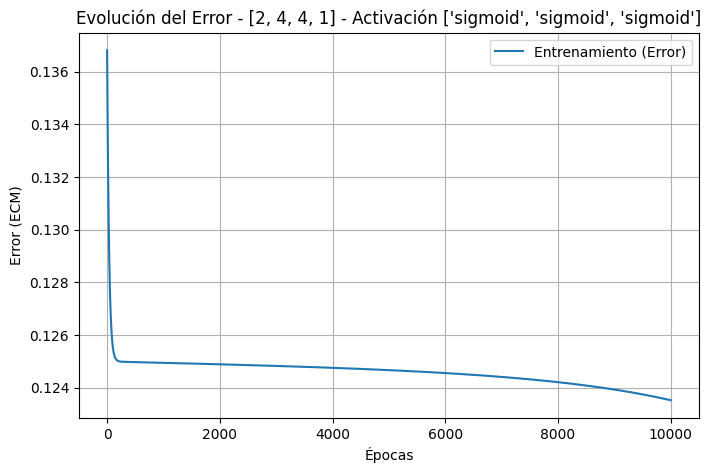

Entrenando con Red 2 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.124960
Error promedio: 0.125031
Desviación estándar del error: 0.000168
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


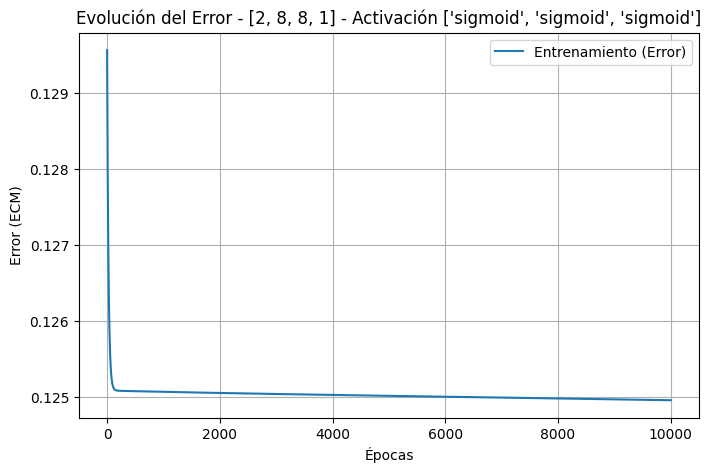

Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.114477
Error promedio: 0.123620
Desviación estándar del error: 0.002687
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


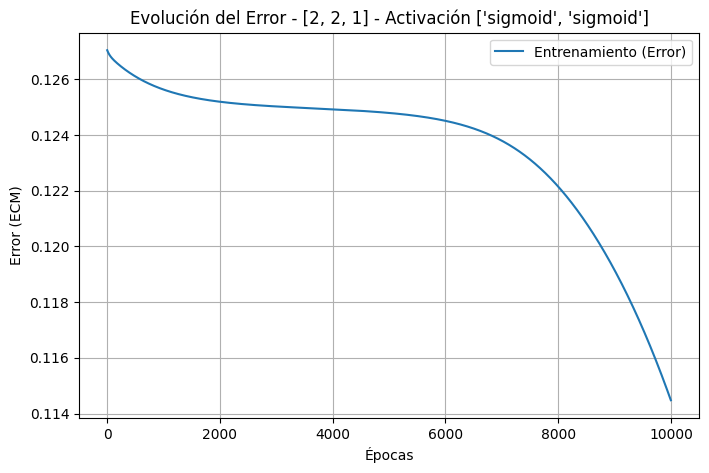

Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.01...
Último error: 0.002957
Error promedio: 0.041051
Desviación estándar del error: 0.044363
La red parece haber convergido con éxito.


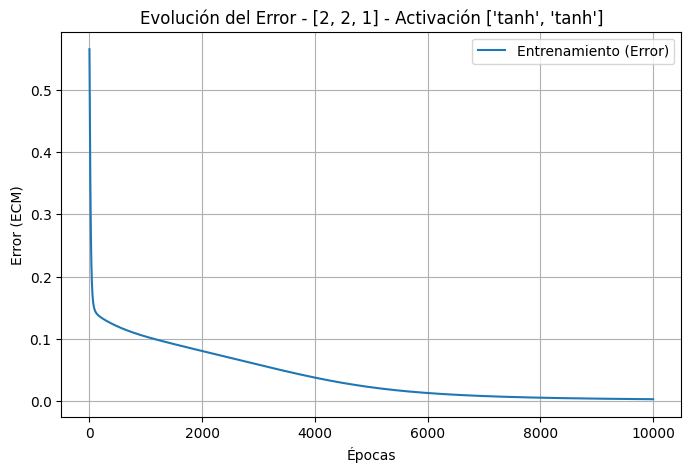

Entrenando con Red 2 -> 4 -> 1 (Tanh) - LR: 0.05...
Último error: 0.000212
Error promedio: 0.006412
Desviación estándar del error: 0.020126
La red parece haber convergido con éxito.


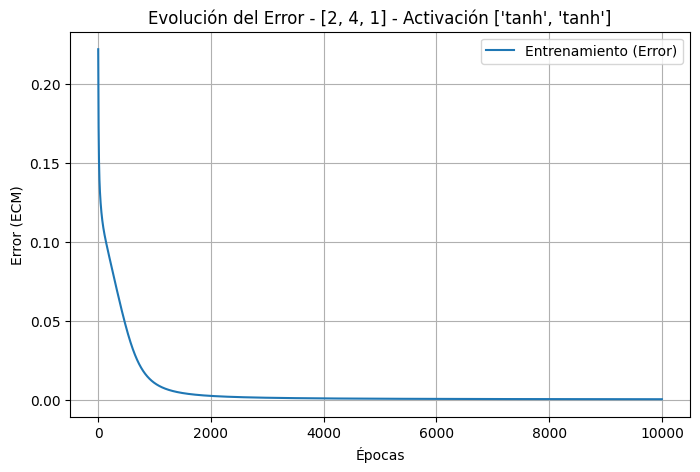

Entrenando con Red 2 -> 4 -> 4 -> 1 (Tanh) - LR: 0.05...
Último error: 0.000109
Error promedio: 0.005462
Desviación estándar del error: 0.020673
La red parece haber convergido con éxito.


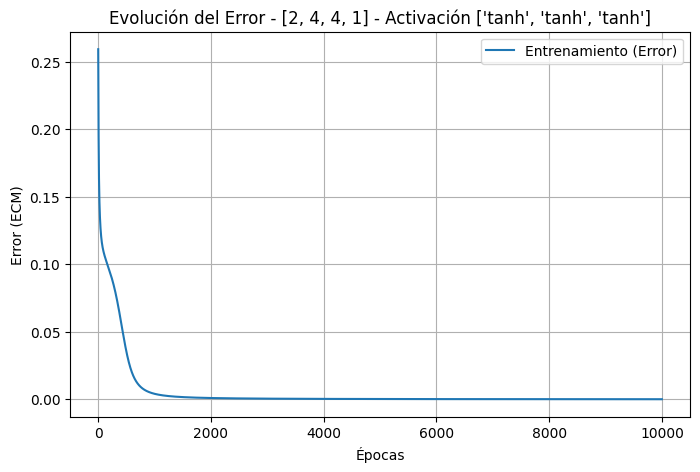

Entrenando con Red 2 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...
Último error: 0.000033
Error promedio: 0.002965
Desviación estándar del error: 0.015553
La red parece haber convergido con éxito.


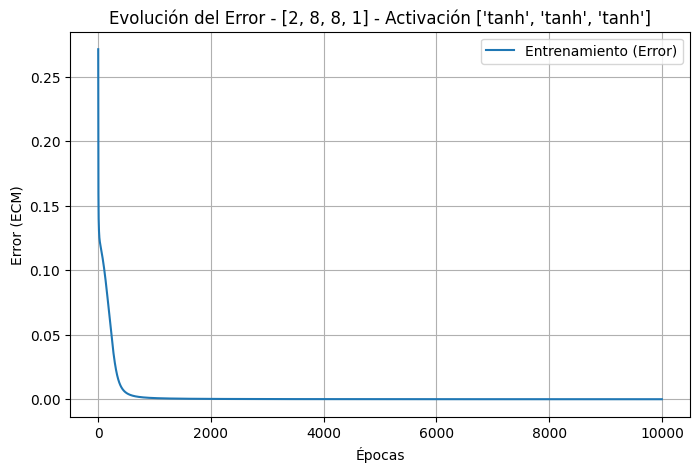

Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.05...
Último error: 0.000183
Error promedio: 0.008680
Desviación estándar del error: 0.025346
La red parece haber convergido con éxito.


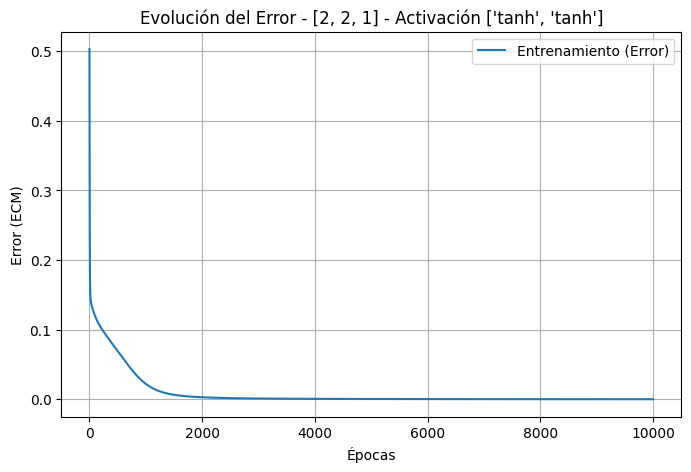

Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.01...
Último error: 0.125165
Error promedio: 0.125491
Desviación estándar del error: 0.001253
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


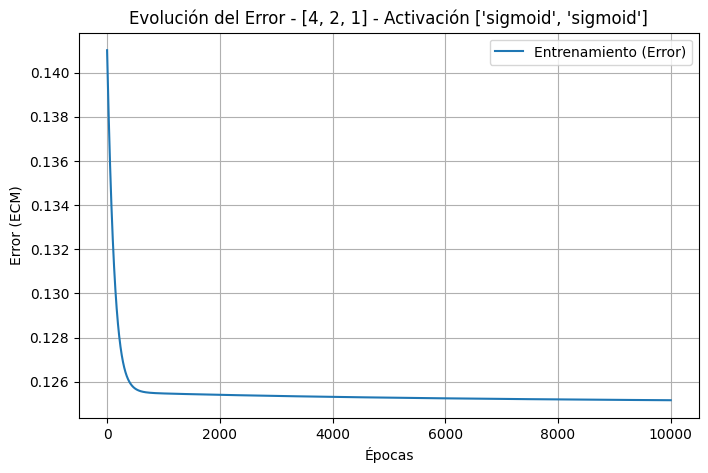

Entrenando con Red 4 -> 4 -> 1 (Sigmoid) - LR: 0.05...


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import csv

# ------------------------------
# Definir los datos XOR de 2 y 4 entradas
# ------------------------------
# XOR de 2 entradas
X_2 = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_2 = np.array([[0], [1], [1], [0]])  # Salida XOR para 2 entradas

# XOR de 4 entradas (simplemente extendiendo el conjunto XOR original)
X_4 = np.array([[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1],
                [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1],
                [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1],
                [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]])

# Ajustar y_4 para que tenga el mismo tamaño que X_4
y_4 = np.array([[0], [1], [1], [0], [1], [0], [0], [1], [1], [0], [0], [1], [0], [1], [1], [0]])  # Salida XOR para 4 entradas

# ============================
# Función para entrenar la red
# ============================
def train_and_plot(X, y, layer_sizes, activations, epochs=10000, batch_size=4, learning_rate=0.1):
    """
    Esta función entrena la red neuronal y grafica la evolución del error durante el entrenamiento.

    Parámetros:
    - X: datos de entrada.
    - y: etiquetas de salida.
    - layer_sizes: lista con el tamaño de las capas [entrada, capa_1, capa_2, ..., salida].
    - activations: lista de funciones de activación para cada capa.
    - epochs: número de épocas de entrenamiento.
    - batch_size: tamaño del batch.
    - learning_rate: tasa de aprendizaje.
    """
    # Crear la red
    mlp = MLP(layer_sizes=layer_sizes, activations=activations, learning_rate=learning_rate)

    # Entrenar
    history = mlp.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=False)

    # Mostrar información clave del historial
    final_loss = history["loss"][-1]  # Último error
    avg_loss = np.mean(history["loss"])  # Promedio del error
    std_loss = np.std(history["loss"])  # Desviación estándar del error

    print(f"Último error: {final_loss:.6f}")
    print(f"Error promedio: {avg_loss:.6f}")
    print(f"Desviación estándar del error: {std_loss:.6f}")
     # Determinar si la red convergió (por ejemplo, si el error final es suficientemente bajo)
    if final_loss < 0.05:
        print("La red parece haber convergido con éxito.")
    else:
        print("La red no ha convergido completamente, puede ser necesario ajustar parámetros.")
        
    # Graficar la evolución del error
    plt.figure(figsize=(8, 5))
    plt.plot(history["loss"], label='Entrenamiento (Error)')
    plt.xlabel('Épocas')
    plt.ylabel('Error (ECM)')
    plt.title(f'Evolución del Error - {layer_sizes} - Activación {activations}')
    plt.legend()
    plt.grid(True)
    plt.show()



# ============================
# Probar varias configuraciones (XOR con 2 entradas)
# ============================

# 1. Red simple con 2 capas (oculta y salida) y activación Sigmoid, learning rate 0.01
print("Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.01...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.01)

# 2. Red con más neuronas en la capa oculta (2 -> 4 -> 1) y activación Sigmoid, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 1 (Sigmoid) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.05)

# 3. Red con 2 capas ocultas para 2 entradas (2 -> 4 -> 4 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 4, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 4. Red con 2 entradas y más complejidad (2 -> 8 -> 8 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 8, 8, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 5. Red muy simple para 2 entradas con solo una capa oculta pequeña (2 -> 2 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 6. Red simple con 2 capas (oculta y salida) y activación Tanh, learning rate 0.01
print("Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.01...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.01)

# 7. Red con más neuronas en la capa oculta (2 -> 4 -> 1) y activación Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 8. Red con 2 capas ocultas para 2 entradas (2 -> 4 -> 4 -> 1) con activación Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 4, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 9. Red con 2 entradas y más complejidad (2 -> 8 -> 8 -> 1) con activación Tanh, learning rate 0.1
print("Entrenando con Red 2 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 8, 8, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.1)

# 10. Red muy simple para 2 entradas con solo una capa oculta pequeña (2 -> 2 -> 1) con activación Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# ============================
# Probar varias configuraciones (XOR con 4 entradas)
# ============================

# 1. Red simple con 2 capas (oculta y salida) y activación Sigmoid, learning rate 0.01
print("Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.01...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.01)

# 2. Red con más neuronas en la capa oculta (4 -> 4 -> 1) y activación Sigmoid, learning rate 0.05
print("Entrenando con Red 4 -> 4 -> 1 (Sigmoid) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.05)

# 3. Red con 2 capas ocultas para 4 entradas (4 -> 4 -> 4 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 4, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 4. Red con 4 entradas y más complejidad (4 -> 8 -> 8 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 8, 8, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 5. Red muy simple para 4 entradas con solo una capa oculta pequeña (4 -> 2 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 6. Red simple con 2 capas (oculta y salida) y activación Tanh, learning rate 0.01
print("Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.01...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.01)

# 7. Red con más neuronas en la capa oculta (4 -> 4 -> 1) y activación Tanh, learning rate 0.05
print("Entrenando con Red 4 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 8. Red con 2 capas ocultas para 4 entradas (4 -> 4 -> 4 -> 1) con activación Tanh, learning rate 0.1
print("Entrenando con Red 4 -> 4 -> 4 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 4, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.1)

# 9. Red con 4 entradas y más complejidad (4 -> 8 -> 8 -> 1) con activación Tanh, learning rate 0.1
print("Entrenando con Red 4 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 8, 8, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.1)

# 10. Red muy simple para 4 entradas con solo una capa oculta pequeña (4 -> 2 -> 1) con activación Tanh, learning rate 0.05
print("Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.05)


### Conclusión:

Los resultados obtenidos a partir de las pruebas realizadas con la red neuronal para el problema XOR, utilizando diferentes funciones de activación (Sigmoid y Tanh) y varios **learning rates**, ofrecen una serie de observaciones clave sobre el comportamiento de la red:

1. **Función Sigmoide**:
   - A pesar de entrenar durante **10,000 epochs**, las redes con función de activación **Sigmoid** no parecen haber convergido completamente. 
   - Aunque los **errores** alcanzan valores bajos, la red muestra **una estabilidad constante** en cuanto al error, pero no logra minimizarlo completamente.
   - **El learning rate** juega un papel fundamental, pero **Sigmoid** sigue sin ofrecer una convergencia ideal en configuraciones más complejas. En redes más pequeñas, los valores de error son mejores, pero no se logra una **convergencia perfecta**.
   
2. **Función Tanh**:
   - **Tanh**, por otro lado, muestra un **rendimiento superior** en la mayoría de las configuraciones de red. Con **learning rates más bajos** (como 0.01 y 0.05), la red **converge mucho más rápido** y los **errores finales** se mantienen muy bajos, a menudo cercanos a cero.
   - La **desviación estándar** también es más pequeña, lo que indica que la red es más estable en su proceso de entrenamiento.
   - Las redes con **Tanh** parecen **aprender de manera más eficiente**, y los resultados muestran una convergencia **más rápida y precisa** en comparación con **Sigmoid**.

3. **Impacto del número de capas y neuronas**:
   - **Incrementar el número de capas y neuronas** (como en las configuraciones 4 -> 4 -> 4 -> 1 o 4 -> 8 -> 8 -> 1) no siempre mejora el rendimiento. De hecho, en algunos casos, las redes más complejas mostraron un mayor error debido a que no lograron converger correctamente. Esto sugiere que el aumento de la complejidad sin una **ajuste adecuado de los parámetros** (como el learning rate) puede llevar a una **convergencia más lenta o ineficiente**.
   
4. **Observaciones generales**:
   - **Learning rate**: La tasa de aprendizaje es un factor crucial en la convergencia de la red. En redes con **Tanh**, los **learning rates más bajos** han dado mejores resultados. Sin embargo, para **Sigmoid**, puede que sea necesario un **learning rate más alto** para mejorar la convergencia, pero incluso con valores altos, la red no logra converger completamente.
   - En resumen, **Tanh** resulta ser más **eficaz y estable** en este caso en comparación con **Sigmoid**.
